# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [161]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier


from imblearn.over_sampling import SMOTE

from scipy.stats import ks_2samp
import warnings
import ast
import re

import umap
import xgboost
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline

from keras.layers import Input, Dense, Activation
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import Flatten, Dropout
from keras.layers import Conv2DTranspose, Reshape
from keras.utils import to_categorical
from keras.optimizers import Adam

In [2]:
pd.__version__

'0.24.2'

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 500
warnings.filterwarnings('ignore')

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
azdias = pd.read_csv('data/azdias.csv')
customers = pd.read_csv('data/customers.csv')

In [5]:
azdias.drop('Unnamed: 0', axis=1, inplace=True)
customers.drop('Unnamed: 0', axis=1, inplace=True)

### Inspecting Azdias 

In [6]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

The dataset has almost 900k entries and 366 features. 

In [7]:
azdias.shape

(891221, 366)

Most of them are numerical and most of them are ordinal. The integer numbers only represent a label for hierachical categories. Columns marked as float are actually comprised by ints but were marked that way only because they contain NaN, which is itself a float. The latest pandas version allows us to use the type Int64 which supports a integer NaN.

In [8]:
azdias.dtypes

LNR                              int64
AGER_TYP                         int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                 object
CAMEO_INTL_2015                 object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                

There are also 6 features of type object. These are categorical variables, except for EINGEFUEGT_AM, which is datetime.

In [9]:
azdias.dtypes[azdias.dtypes=='object']

CAMEO_DEU_2015              object
CAMEO_DEUG_2015             object
CAMEO_INTL_2015             object
D19_LETZTER_KAUF_BRANCHE    object
EINGEFUEGT_AM               object
OST_WEST_KZ                 object
dtype: object

In [10]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


Most features contain NaNs which appear in blocks. 

In [11]:
azdias.isnull().sum().values

array([     0,      0,  73499,  73499, 810163, 861722, 885051, 890016,
       262947,  93148,  97008,  73499,  73499,  93148,  73499,  97216,
        93740,  98979,  98979,  98979,   4854,   4854,   4854,   4854,
         4854,   4854,   4854,   4854,      0,      0,      0,      0,
            0,      0,      0,      0, 257113,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0, 257113,      0,      0,
            0, 257113,      0,      0,      0, 257113, 257113,      0,
            0,      0,      0,      0,      0, 257113,      0,      0,
            0,      0,      0,      0,      0, 257113,      0,      0,
            0,      0,      0,      0,      0, 257113,      0,      0,
            0,      0,      0,      0, 257113,      0,      0,      0,
        93148,  93148,  73499,  93740, 654153,      0,      0,      0,
            0,      0,      0,      0,  93155,  93148,  93155,      0,
      

### Inspecting Customers

In [12]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

Customers data has three extra columns.

In [13]:
customers.shape

(191652, 369)

These are CUSTOMER_GROUP, ONLINE_PURCHASE, PRODUCT_GROUP

In [14]:
extra_cols = list(set(customers.columns.values).difference(set(azdias.columns.values)))
extra_cols

['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE']

Two of them are objects and the other is int.

In [15]:
customers.dtypes[extra_cols]

CUSTOMER_GROUP     object
PRODUCT_GROUP      object
ONLINE_PURCHASE     int64
dtype: object

The customers dataframe is also full of NaNs.

In [16]:
customers.isnull().sum().values

array([     0,      0,  46596,  46596, 179886, 186552, 190377, 191416,
        51842,  49927,  52110,  46596,  46596,  49927,  46596,  50476,
        49959,  50428,  50428,  50428,   3213,   3213,   3213,   3213,
         3213,   3213,   3213,   3213,      0,      0,      0,      0,
            0,      0,      0,      0,  47697,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,  47697,      0,      0,
            0,  47697,      0,      0,      0,  47697,  47697,      0,
            0,      0,      0,      0,      0,  47697,      0,      0,
            0,      0,      0,      0,      0,  47697,      0,      0,
            0,      0,      0,      0,      0,  47697,      0,      0,
            0,      0,      0,      0,  47697,      0,      0,      0,
        49927,  49927,  46596,  49959,  85283,      0,      0,      0,
            0,      0,      0,      0,  49927,  49927,  49927,      0,
      

#### Attributes [-1,0] indicate missing or unknown

In [17]:
dias_attr = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', skiprows=[0])
dias_attr.drop('Unnamed: 0', axis=1, inplace=True)
dias_attr

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [18]:
dias_info = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', skiprows=[0])
dias_info.drop('Unnamed: 0', axis=1, inplace=True)
dias_info.replace({'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24':'D19_GESAMT_ANZ_12-24',
                  'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24':'D19_BANKEN_ ANZ_12-24',
                 'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24':'D19_TELKO_ ANZ_12-24',
                 'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24':'D19_VERSI_ ANZ_12-24',
                 'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24':'D19_VERSAND_ ANZ_12-24'},inplace=True)
dias_info

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


#### feature 'EINWOHNER', 'PLZ', 'GKZ', 'PLZ8' are not in azdias

## Data Cleaning

#### Preliminary cleaning

In [19]:
def pre_clean(df):
    list_numeric = df.dtypes[(df.dtypes=='float64') | (df.dtypes=='int64') ].index.values.tolist()
    df[list_numeric] = df[list_numeric].astype('Int64')
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W':0, 'O':1}).astype("Int64")
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace({'XX':np.nan})
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace({'X':np.nan})
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace({'XX':np.nan})
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].replace({0:np.nan}).astype('Int64')
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].replace({0:np.nan}).astype('Int64')
    return df.drop('EINGEFUEGT_AM', axis=1)

In [20]:
azdias = pre_clean(azdias)

### Missing Data - convert missing value codes to NaNs


In [21]:
def map_values(x, dict_missing):
    try:
        return dict_missing[x]
    except:
        return x
    
def missing_values(df):
    missing_df = dias_attr.query('Meaning=="unknown"')[['Attribute','Value']].dropna().set_index('Attribute')
    missing_df = missing_df['Value'].astype('str').str.split(',',expand=True).T
    missing_df = missing_df.applymap(lambda x: int(x) if x!=None else -100)

    for i in missing_df.columns.values:
        for j in [0,1]:
            dict_missing = {missing_df.loc[j,i]:np.nan}
            try:
                df[i] = df[i].map(lambda x: map_values(x, dict_missing)).astype('Int64')
            except:
                pass

    return df

In [22]:
%%time
azdias = missing_values(azdias)

CPU times: user 14min 7s, sys: 12.4 s, total: 14min 20s
Wall time: 3min 42s


### Assess missing data per feature

Features with more than 445k entries missing were dropped

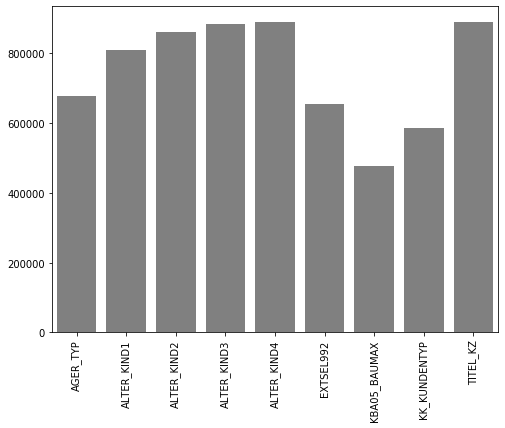

In [23]:
null_df = azdias.isnull().sum()
null_df = null_df[null_df > 445E3]
fig,ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(null_df.index, null_df.values, color='gray')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

#### dropped values correspond to 18% of all missing values

In [24]:
azdias[null_df.index].isnull().sum().sum() / azdias.isnull().sum().sum()

0.18222273002095582

In [25]:
feature_drop_list = pd.Series(azdias.isnull().sum()).where(lambda x:  x > 445E3).dropna().index.tolist()
feature_drop_list

['AGER_TYP',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [26]:
def drop_features(df, feature_drop_list):
    return df.drop(feature_drop_list, axis=1)

In [27]:
azdias = drop_features(azdias, feature_drop_list)

### Assess missing data per row

In [28]:
missing_rows = azdias.isnull().sum(axis=1)

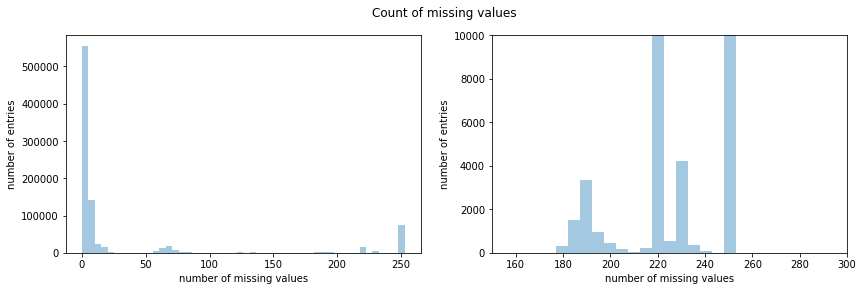

In [29]:
fig,ax = plt.subplots(figsize=(14,4), ncols=2, nrows=1)
sns.distplot(missing_rows, kde=False, ax=ax[0])
ax[0].set_xlabel('number of missing values')
ax[0].set_ylabel('number of entries')
sns.distplot(missing_rows, kde=False, ax=ax[1])
ax[1].set_xlim([150,300])
ax[1].set_ylim([0,10000])
ax[1].set_xlabel('number of missing values')
ax[1].set_ylabel('number of entries');
plt.suptitle('Count of missing values');

#### Cutoff for missing values is 180

In [30]:
azdias_below = azdias[azdias.isnull().sum(axis=1)<180].copy().reset_index().drop('index', axis=1)
azdias_above = azdias[azdias.isnull().sum(axis=1)>=180].copy().reset_index().drop('index', axis=1)

#### We apply a KS test to check if the selected rows are overall different than the main body of data. The null hypothesis is that both groups are identical.

In [31]:
list_numeric = azdias.dtypes[(azdias.dtypes=='int64') | 
                             (azdias.dtypes=='Int64') | 
                             (azdias.dtypes=='float64')].index[1:].tolist()
columns_not_missing = (azdias_above.isnull().sum()==0).index[1:].tolist()
columns_test = set(columns_not_missing).intersection(set(list_numeric))

In [32]:
ks_df = pd.DataFrame(azdias[columns_test].columns, columns=['col'])
  
def hypothesis_test(df1, df2, cols):
    stats = []
    pvalues = []
    for col in cols:
        counts_main = df1[col].value_counts().sort_index()
        counts_drop = df2[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues

stats, pvalues = hypothesis_test(azdias_below[columns_test], azdias_above[columns_test], azdias_below[columns_test].columns.values)
ks_df['stats'] = stats
ks_df['pvalues'] = pvalues
ks_df.dropna(axis=0, inplace=True)

In [33]:
ks_df.head()

,col,stats,pvalues
1,D19_VERSI_DATUM,0.9,0.000170
2,UMFELD_JUNG,1.0,0.003781
10,PLZ8_ANTG2,1.0,0.003781
11,CJT_TYP_3,1.0,0.003781
12,D19_TELKO_ONLINE_DATUM,0.7,0.006899


#### The KS test showed that 83% of the columns have a low p-value. This suggests that the groups are not equal. However, note that this conclusion is not based on a formal result which would require a treatment for multiple comparisons.

In [34]:
ks_df[ks_df['pvalues']<0.05].shape[0] / ks_df.shape[0]

0.8232044198895028

Text(0.5, 1.0, 'p-value per column for removed data')

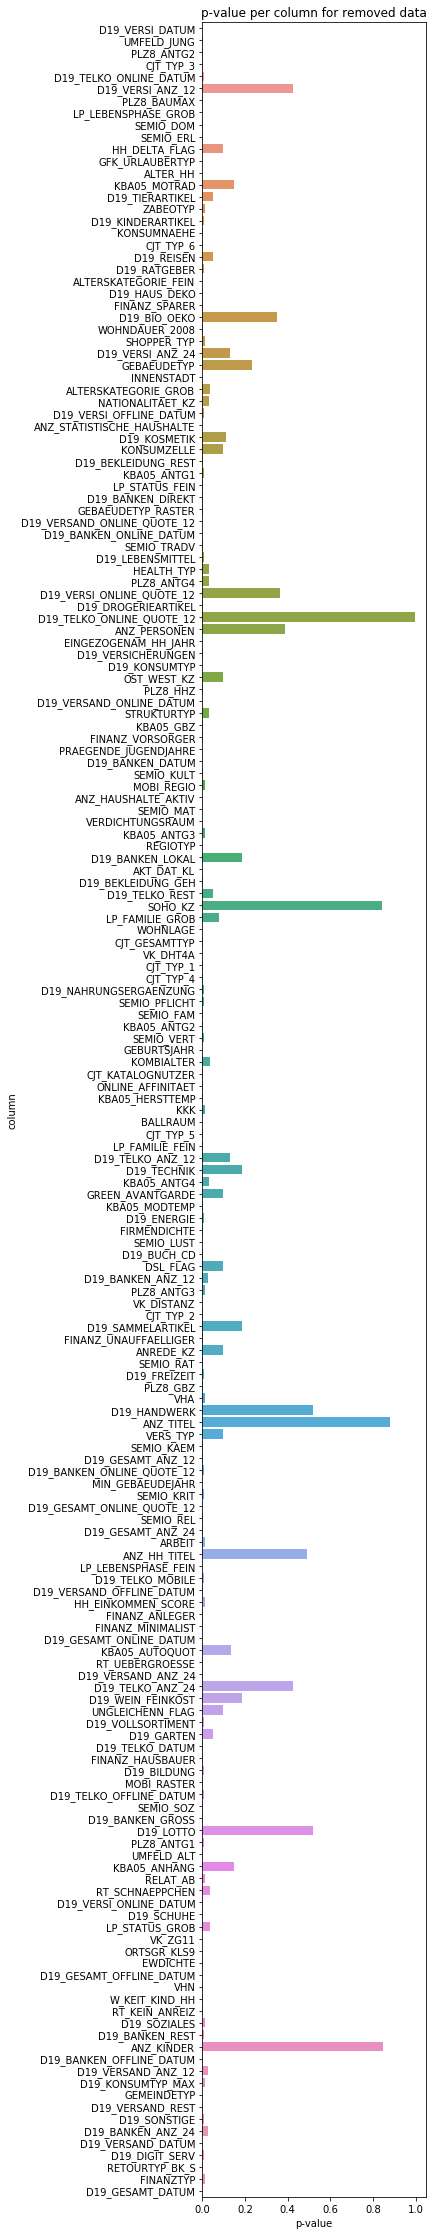

In [35]:
fig,ax = plt.subplots(figsize=(4,40))
sns.barplot(y='col', x='pvalues', data=ks_df, ax=ax)
ax.set_xlabel('p-value')
ax.set_ylabel('column');
ax.set_title('p-value per column for removed data')

We therefore take only azdias_below.

In [36]:
def drop_rows(df):
    return df[df.isnull().sum(axis=1)<180].copy().reset_index().drop('index', axis=1)

In [37]:
azdias2 = drop_rows(azdias.copy())

## Data Imputation

#### first update list of numeric and object columns

#### Impute ints using median, floats using mean and objects using most frequent value

In [38]:
def impute_numeric(df, strategy):
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer.fit(df)
    return imputer.transform(df)

def impute_object(df):
    list_mode = df.apply(lambda x: x.mode()[0]).values.tolist()
    list_columns = df.columns.values.tolist()
    dict_mode = {i:j for i,j, in zip(list_columns, list_mode)}
    return df.fillna(value=dict_mode)
    
def impute_calc(df):
    list_numeric = df.dtypes[(df.dtypes=='int64') | 
                             (df.dtypes=='Int64') | 
                             (df.dtypes=='float64')].index[1:].tolist()
    df[list_numeric] = impute_numeric(df[list_numeric].astype('Int64'),'median').astype('int64')
    list_objects = df.dtypes[(df.dtypes=='object')].index.tolist()
    df[list_objects] = impute_object(df[list_objects])
    
    return df

In [39]:
azdias2 = impute_calc(azdias2)

In [40]:
azdias2.isnull().values.any()

False

### Re-encode mixed features

#### PRAEGENDE_JUGENDJAHRE

#### Two new attributes were created 

#### Levels for PRAGENDE_JUGENDJAHRE_intervall  
#### Dictionary pji_dict
- 1: 40s
- 2: 50s
- 3: 60s
- 4: 70s
- 5: 80s
- 6: 90s

#### Levels for PRAGENDE_JUGENDJAHRE_trend
#### Dictionary pjt_dict
- 0: mainstream
- 1: avantgarde

In [41]:
def pragende_jugendjahre(df):
    pji_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    pjt_dict = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df['PRAEGENDE_JUGENDJAHRE_intervall'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pji_dict[int(x)])
    df['PRAEGENDE_JUGENDJAHRE_trend'] = \
    df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pjt_dict[int(x)])
# drop original attribute from dataset
    return df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [42]:
azdias2 = pragende_jugendjahre(azdias2)

### Mixed-type variable CAMEO_INTL_2015

#### Two new attributes were created

#### Levels for CAMEO_INTL_2015_reichtum
#### Dictionary cir_dict
- 1: Wealthy
- 2: Prosperous
- 3: Comfortable
- 4: Less Affluent
- 5: Poorer

#### Levels for CAMEO_INTL_2015_leben
#### Dictionary cil_dict
- 1: Pre-Family Couples & Singles
- 2: Young Couples With Children
- 3: Families With School Age Children
- 4: Older Families &  Mature Couples
- 5: Elders In Retirement

In [43]:
def cameo_intl_2015(df):
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('int64')
    cir_dict = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 
            35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
    cil_dict = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 
            35:5, 41:1, 42:2, 43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}
    df['CAMEO_INTL_2015_reichtum'] = df['CAMEO_INTL_2015'].map(cir_dict).astype('int64')
    df['CAMEO_INTL_2015_leben'] = df['CAMEO_INTL_2015'].map(cil_dict).astype('int64')
    return df.drop('CAMEO_INTL_2015', axis=1)

In [44]:
azdias2 = cameo_intl_2015(azdias2)

### Mixed-type variable LP_LEBENSPHASE_FEIN

#### Three new attributes were created.

#### Levels for LP_LEBENSPHASE_FEIN_alter
#### Dictionary llfa_dict

- 1: young age
- 2: middle age
- 3: retirement age
- 4: advanced age
- 5: higher age

#### Levels for LP_LEBENSPHASE_FEIN_verdiener
#### Dictionary llfv_dict

- 1: low-income earners 
- 2: average earner
- 3: independent
- 4: homeowner
- 5: top earner
- 6: wealthy

#### Levels for LP_LEBENSPHASE_FEIN_familie
#### Dictionary llff_dict

- 1: single
- 2: single parent
- 3: multiperson households
- 4: families
- 5: couples

In [45]:
def lp_lebensphase_fein(df):
    df['LP_LEBENSPHASE_FEIN'] = df['LP_LEBENSPHASE_FEIN'].astype('int64')
    llfa_dict={1:1, 2:2, 3:1, 4:2, 5:4, 6:3, 7:4, 8:3, 9:2, 10:6, 11:4, 12:3, 13:5, 14:1, 15:5, 
           16:5, 17:2, 18:1, 19:5, 20:5, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1, 
           31:5, 32:5, 33:1, 34:1, 35:1, 36:5, 37:4, 38:3, 39:2, 40:3}

    llfv_dict={1:1, 2:1, 3:2, 4:2, 5:1, 6:1, 7:2, 8:2, 9:3, 10:3, 11:4, 12:4, 13:5, 14:2, 15:1, 
           16:2, 17:3, 18:6, 19:4, 20:5, 21:1, 22:2, 23:5, 24:1, 25:2, 26:3, 27:4, 28:5, 29:1, 30:2, 
           31:1, 32:2, 33:3, 34:4, 35:5, 36:3, 37:4, 38:4, 39:5, 40:5}

    llff_dict={1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:5, 15:5, 
           16:5, 17:5, 18:5, 19:5, 20:5, 21:2, 22:2, 23:2, 24:4, 25:4, 26:4, 27:4, 28:4, 29:3, 30:3, 
           31:3, 32:3, 33:3, 34:3, 35:3, 36:3, 37:3, 38:3, 39:3, 40:3}

    # transformation of LP_LEBENSPHASE_FEIN
    df['LP_LEBENSPHASE_FEIN_alter'] = df['LP_LEBENSPHASE_FEIN'].map(llfa_dict).astype('int64')
    df['LP_LEBENSPHASE_FEIN_verdiener'] = df['LP_LEBENSPHASE_FEIN'].map(llfv_dict).astype('int64')
    df['LP_LEBENSPHASE_FEIN_familie'] = df['LP_LEBENSPHASE_FEIN'].map(llff_dict).astype('int64')
    # drop original attribute from dataset
    return df.drop('LP_LEBENSPHASE_FEIN', axis=1)



In [46]:
azdias2 = lp_lebensphase_fein(azdias2)

### Mixed-type variable LP_LEBENSPHASE_GROB

#### Three new attributes were created

#### Levels for LP_LEBENSPHASE_GROB_alter:
#### Dictionary llga_dict  
- 1: young age  
- 2: middle age  
- 3: higher age  

#### Levels for LP_LEBENSPHASE_GROB_verdiener:
#### Dictionary llgv_dict  
- 0: low-income and average earner  
- 1: high-income  

#### Levels for LP_LEBENSPHASE_GROB_familie:
#### Dictionary llgf_dict  
- 1: single
- 2: couples
- 3: families
- 4: multiperson
- 5: single parents

In [47]:
def lp_lebensphase_grob(df):
    df['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].astype('int64')
    llga_dict={1:1, 2:3, 3:2, 4:2, 5:2, 6:2, 7:2, 8:2, 9:1, 10:3, 11:1, 12:3}
    llgv_dict={1:0, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:0, 11:1, 12:1}
    llgf_dict={1:1, 2:1, 3:1, 4:2, 5:2, 6:5, 7:3, 8:3, 9:4, 10:4, 11:4, 12:4}
    
    df['LP_LEBENSPHASE_GROB_alter'] = df['LP_LEBENSPHASE_GROB'].map(llga_dict).astype('int64')
    df['LP_LEBENSPHASE_GROB_verdiener'] = df['LP_LEBENSPHASE_GROB'].map(llgv_dict).astype('int64')
    df['LP_LEBENSPHASE_GROB_familie'] = df['LP_LEBENSPHASE_GROB'].map(llgf_dict).astype('int64')
    # drop original attribute from dataset
    return df.drop('LP_LEBENSPHASE_GROB', axis=1)

In [48]:
azdias2 = lp_lebensphase_grob(azdias2)

### Mixed-type variable PLZ8_BAUMAX

#### Two new attributes were created

PLZ8_BAUMAX 	most common building-type within the PLZ8 	1 	mainly 1-2 family homes
2038 	NaN 	NaN 	2 	mainly 3-5 family homes
2039 	NaN 	NaN 	3 	mainly 6-10 family homes
2040 	NaN 	NaN 	4 	mainly >10 family homes
2041 	NaN 	NaN 	5 	mainly business building

#### Levels for PLZ8_BAUMAX_geschaft:
#### Dictionary pbg_dict  
- 0: business building  
- 1: residential building 

#### Levels for PLZ8_BAUMAX_nummer:
#### Dictionary pbn_dict  
- 0: mainly 1-2 family homes
- 1: mainly 3-5 family homes
- 2: mainly 6-10 family homes
- 3: mainly >10 family homes

In [49]:
#def plz8_baumax(df):
#    pbg_dict={5:0, 1:1, 2:1, 3:1, 4:1}
#    pbn_dict={1:1, 2:2, 3:3, 4:4, 5:0}
#    
#    df['PLZ8_BAUMAX_geschaft'] = df['PLZ8_BAUMAX'].map(pbg_dict).astype('Int64')
#    df['PLZ8_BAUMAX_nummer'] = df['PLZ8_BAUMAX'].map(pbn_dict).astype('Int64')

    # drop original attribute from dataset
#    return df.drop('PLZ8_BAUMAX', axis=1)

#azdias_below2 = plz8_baumax(azdias_below2)

## One-hot encoding

In [50]:
def make_lists(df):
    list_all = df.columns.tolist()[1:]
    list_onehot = dias_info['Attribute'].str.extract(r'([0-9A-Z_]*TYP)', expand=True).\
    dropna().\
    stack().\
    values.\
    tolist()
    list_onehot = list(set(list_onehot).intersection(set(list_all)))
    list_binary = [column for column in df.columns.tolist() if df[column].value_counts().shape[0]==2]
    #list_onehot = set(list_onehot).difference(set(list_binary))
    list_scale = list(set(list_all).difference(set(list_binary)).difference(set(list_onehot)))
    
    # specific corrections
    list_scale.remove('D19_LETZTER_KAUF_BRANCHE')
    list_onehot.append('D19_LETZTER_KAUF_BRANCHE')
    list_scale.remove('CAMEO_DEUG_2015')
    list_onehot.append('CAMEO_DEUG_2015')
    list_scale.remove('CAMEO_DEU_2015')
    list_onehot.append('CAMEO_DEU_2015')
    
    return list_onehot, list_binary, list_scale

In [51]:
list_onehot, list_binary, list_scale = make_lists(azdias2)

In [52]:
azdias2.isnull().values.any()

False

In [53]:
def adjust_types(df):
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('int')
    return df.drop('LNR', axis=1)

In [54]:
azdias2 = adjust_types(azdias2)

In [55]:
onehot = OneHotEncoder()
onehot.fit(azdias2[list_onehot])
df_onehot = pd.DataFrame(data = onehot.transform(azdias2[list_onehot]).todense(), 
                         columns=onehot.get_feature_names())

In [56]:
df_onehot.shape, azdias2.shape

((791314, 148), (791314, 361))

In [57]:
azdias3 = pd.concat([azdias2.drop(list_onehot, axis=1), df_onehot], axis=1)

In [58]:
azdias3.shape

(791314, 496)

### Scaling

In [59]:
scaler = StandardScaler()
azdias3[list_scale] = scaler.fit_transform(azdias3[list_scale])

In [60]:
azdias3.describe()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINI

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [61]:
def pca_components(df, minRange, maxRange):
    evr = {}
    for i in range(minRange, maxRange):
        pca_model = PCA(n_components=i)
        X_pca = pca_model.fit_transform(df)
        evr[i] = pca_model.explained_variance_ratio_.sum()
    return evr

def generate_pca(df, n_components):
    '''
    Generates PCA model
    
    INPUT: df - scaled dataframe
           n_components - number of components for the model
           
    OUTPUT: pca_model - PCA object
            var_pca - dataframe with components and explained variances
            X_pca - numpy array with transformed data
    '''
    pca_model = PCA(n_components)
    X_pca = pca_model.fit_transform(df)
    components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df.keys())
    ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)
    dimensions = ['Dim {}'.format(i) for i in range(len(pca_model.components_))]
    components.index = dimensions
    variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained_Variance'])
    variance_ratios.index = dimensions
    var_pca = pd.concat([variance_ratios, components], axis=1)
    
    return pca_model, var_pca, X_pca

def scree_plot_pca(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantiating of PCA in scikit learn
            
    OUTPUT: None
    '''
    
    num_comp = len(pca.explained_variance_ratio_)
    idx = np.arange(num_comp)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(16,6))
    ax = plt.subplot(111)
    ax.bar(idx, vals*10)
    ax.plot(idx, np.cumsum(vals),'r--')
    
    for i in range(num_comp):

        ax.annotate(r"%s" % ((str(vals[i]*100)[:4])), 
                    (idx[i], vals[i]*10), 
                    va="bottom", 
                    ha="center", 
                    fontsize=8)
        
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    
    plt.title("Explained Variance per Principal Component")

In [62]:
#evr = pca_components(azdias3, 100, 150)

We chose 124 components because it is the smallest number of components for 80% explained variance ratio.

In [63]:
#n_dim = [key for key, value in evr.items() if value>=0.8][0]
#n_dim

In [64]:
n_dim = 124
list_pca = azdias3.columns.values.tolist()
pca_model, var_pca, X_pca = generate_pca(azdias3, n_dim)

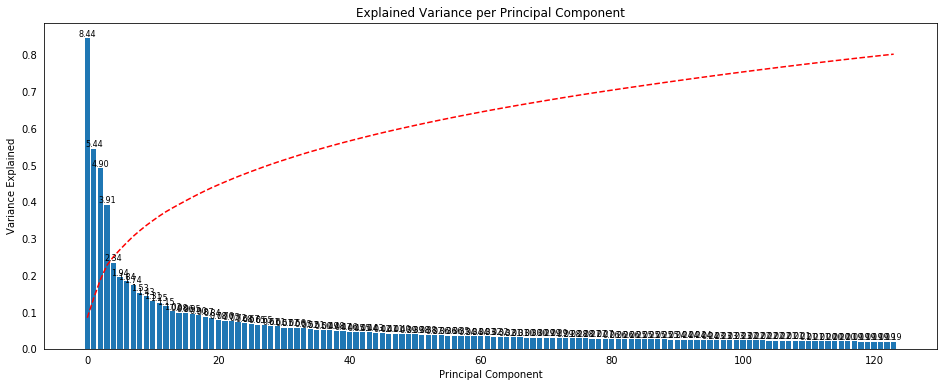

In [65]:
scree_plot_pca(pca_model)

### K-Means

Our first attempt with clustering was with k-means.

In [66]:
def dist_centroid(X_pca, k_model):
    '''
    Calculates the average distance between points in a certain cluster
    and the cluster centroid.
    
    INPUT: X_pca - transformed PCA dimension
           k_model - instantiated k-means model
           
    OUTPUT: scalar mean distance
    '''
    dist = []
    for i, c in enumerate(k_model.cluster_centers_):
        a = np.array([np.sqrt(np.dot((x - c),(x - c))) for x in X_pca[k_model.labels_ == i]])
        #print(a.shape)
        #print(a.sum())
        #print((k_model.labels_==i).sum())
        dist.append(a.sum() / (k_model.labels_ == i).sum())
    
    return np.array(dist).mean()

def scree_plot_kmeans(X_pca):
    '''
    Generates scree plot for k-means model
    with 1 to 20 components
    
    INPUT: X_pca - numpy array with transformed data
           
    OUTPUT: scalar mean distance
    '''
    
    k_score = []
    k_dist = []
    k_step = []
    for k in range(5,25):
        k_model = KMeans(n_clusters = k, random_state=34).fit(X_pca)
        a = k_model.score(X_pca)
        k_score.append(a)
        b = dist_centroid(X_pca, k_model)
        print('clusters: {}, score: {}, dist: {}'.format(k, a, b))
        k_dist.append(b)
        k_step.append(k)
    return k_step, k_dist, k_score

In [67]:
#k_step, k_dist, k_score = scree_plot_kmeans(X_pca)

In [68]:
def calc_clusters(method):
    model= method.fit(X_pca)
    df = pd.DataFrame(X_pca)
    df['clusters'] = model.labels_
    
    return df, model

def plot_clusters(df):
    palette = sns.color_palette("Set2",11).as_hex()
    colors = []
    colors.extend([palette[10], palette[9], palette[8], palette[7], palette[6]])

    fig, axis = plt.subplots(1, figsize=(8,6))

    sns.scatterplot(x=0, y=1, data=df, ax=axis, hue='clusters')

def plot_pops(df):
    df_ = df.groupby('clusters').agg({'clusters':'size'}).rename(columns={'clusters':'size'}).reset_index()
    sns.barplot(x = 'clusters', y = 'size', data=df_, color='gray')    


In [69]:
n_clusters = 20
kmeans_df, kmeans =  calc_clusters(KMeans(n_clusters = n_clusters, random_state=34))

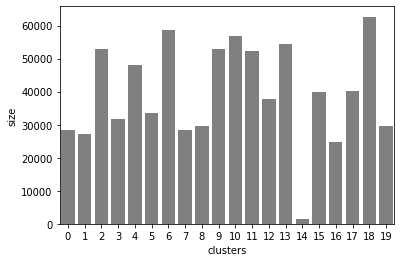

In [70]:
plot_pops(kmeans_df)

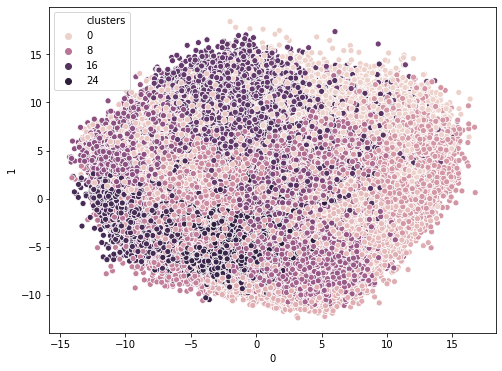

In [71]:
plot_clusters(kmeans_df)

### Apply data processing to customers

In [72]:
def clean_customer(df):
    df_extra = df[['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE']]
    return df.drop(['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'], axis=1), df_extra

def pipeline(df):
    df = pre_clean(df)
    df = missing_values(df)
    df = drop_features(df, feature_drop_list)
    df = drop_rows(df)
    df = impute_calc(df)
    df = pragende_jugendjahre(df)
    df = cameo_intl_2015(df)
    df = lp_lebensphase_fein(df)
    df = lp_lebensphase_grob(df)
    df = adjust_types(df)
    #df, df_extra = clean_customer(df)
    df_onehot = pd.DataFrame(data = onehot.transform(df[list_onehot]).todense(), 
                         columns=onehot.get_feature_names())
    df = pd.concat([df.drop(list_onehot, axis=1), df_onehot], axis=1)
    df[list_scale] = scaler.transform(df[list_scale])
    X_pca = pca_model.transform(df[list_pca])
    kmeans_pipe = pd.DataFrame(X_pca)
    kmeans_pipe['clusters'] = kmeans.predict(X_pca)
    
    return df, kmeans_pipe

In [73]:
customers_mod = customers.drop(['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'],axis=1)

In [74]:
df_customers, kmeans_pipe = pipeline(customers_mod.copy())

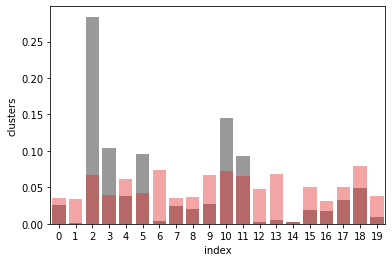

In [75]:
df_agg = kmeans_pipe['clusters'].value_counts(normalize=True).reset_index()
df_agg_azdias = kmeans_df['clusters'].value_counts(normalize=True).reset_index()
sns.barplot(x = 'index', y = 'clusters', data=df_agg, color='black', alpha=0.4)
sns.barplot(x = 'index', y = 'clusters', data=df_agg_azdias, color='red', alpha=0.4)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [76]:
mailout_train = pd.read_csv('data/mailout_train.csv')

In [77]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [78]:
mailout_train.shape

(42962, 367)

In [79]:
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [80]:
df_mailout_train, kmeans_train = pipeline(mailout_train.copy())

In [81]:
df_mailout_train.shape, kmeans_train.shape

((35096, 497), (35096, 125))

In [82]:
kmeans_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,clusters
0,-5.267240,-4.682783,2.555490,6.882862,-0.269012,3.552548,-1.840130,-0.246685,-0.694523,-0.222302,1.133839,-0.373039,0.021856,-0.939402,-1.938746,1.522537,1.035527,0.681282,-2.321495,-2.142330,-0.880570,0.104297,0.344547,0.371301,0.386238,-1.482352,-1.271943,-0.746240,1.246341,2.396120,2.016150,0.091156,-1.568733,1.884847,-2.981639,1.850127,-1.428143,-2.075047,1.288044,0.465562,-0.339946,0.182625,-0.508845,-1.013438,0.562574,0.472867,0.359051,0.751743,0.424918,0.755407,1.374805,0.177631,1.117862,-1.613212,-0.740474,-0.461738,-0.641312,0.713196,-0.309789,0.317064,-0.741096,1.065255,-0.826898,-0.688845,0.265987,-1.526969,-1.234375,0.677675,-0.171211,0.927015,-0.249996,0.177999,0.203166,-1.428465,-0.223674,1.351920,-0.259587,0.497844,-0.571007,0.205837,0.346072,0.156151,0.087003,0.161242,-0.007062,0.615881,-0.648536,0.170966,-0.300763,-1.742862,0.648702,0.006532,1.193954,-0.685540,1.028127,0.199536,1.587013,0.084274,0.008595,-0.258132,-0.134825,0.200727,0.211525,0.449383,-0.615100,-0.087251,1.634853,-0.238606,-1.880810,-1.979347,0.420690,-0.547603,0.053761,-1.842922,-0.401139,-0.628062,-0.049533,0.524154,0.777137,-0.475407,0.297226,-0.229076,-0.431377,0.747979,17
1,9.689803,0.165826,-3.357596,1.243669,-2.281932,2.640778,-2.913675,-1.947850,1.150239,-0.378526,0.758954,-0.093471,1.820190,0.722259,4.230713,0.507390,0.885122,-1.031635,-0.873781,-1.156792,-1.101361,3.382390,0.567499,6.842714,4.452721,-1.532378,2.609588,1.103383,2.948687,-1.921008,1.544023,-1.692301,1.484493,0.275671,2.439190,-2.219932,1.804369,-2.214536,-0.490657,-2.775770,-4.512680,0.678522,0.704780,-0.596258,-1.760439,-0.211474,0.356606,1.041063,0.504099,0.814787,-1.376468,0.793294,-0.907210,-1.388078,0.037049,-1.278790,0.768271,1.867001,1.321469,-2.215332,1.117080,1.366778,-0.298311,0.057497,-1.308262,-1.351830,1.152324,0.650718,0.906975,-0.444552,-0.329703,0.753815,0.352075,-1.363092,-1.034220,-0.718442,-1.103229,0.407679,0.389455,0.791549,1.236125,-1.526184,-0.508539,1.893276,-1.893709,2.750213,0.846765,0.496193,1.928454,0.496898,0.922716,0.835390,3.674712,-1.920344,-1.995796,-2.220726,-1.573985,3.893657,-0.759397,0.202781,1.161446,0.648052,0.201582,-0.906442,-2.216631,0.014435,-0.878515,0.214846,-0.385050,0.790248,-0.288303,0.203182,-1.099569,-1.479792,0.828429,-0.928922,-0.635151,-1.520011,-0.803938,-0.795495,-0.110084,0.910468,-0.593223,-1.524735,5
2,3.235419,-4.259503,-2.834992,5.605305,5.116398,0.104928,3.849248,-1.093617,-1.470367,4.312312,-0.449089,1.332083,-1.292339,-2.523875,0.392272,-2.083216,-1.568139,0.303360,-2.772573,1.762214,0.883710,1.001884,-1.863555,0.817502,0.721020,-1.104481,-0.710398,0.436756,0.241833,-1.491881,-1.467756,2.814637,0.135583,0.183182,-2.038027,2.047113,0.533283,-1.591511,0.425227,0.396106,-0.953890,1.038066,0.292653,1.082992,0.215799,-0.953511,-0.373356,1.535931,2.908623,-2.041221,1.259627,-1.528032,-1.729227,-0.050332,-0.290534,0.619557,-1.536349,1.226265,-1.758801,-1.122084,-0.145577,0.435993,-0.628222,-0.218292,2.241820,-1.748054,-0.032365,1.451371,-2.251062,-1.005909,0.620211,-1.915436,-1.025733,-0.382745,1.071607,-0.906703,0.393651,0.054968,-0.780826,0.795346,-0.729841,0.178678,0.222046,0.607119,1.434887,0.799886,-0.158017,0.746880,0.427946,0.082136,-0.861952,-0.377976,-0.531146,0.290107,-0.821194,0.680573,0.519820,-1.358608,0.040091,-0.942588,1.688357,-0.660501,0.203792,-0.915917,-1.222805,-1.289815,-0.974243,1.963775,-0.169889,0.052112,-1.544174,1.929115,-0.579647,-0.876247,-1.514013,0.487547,1.265727,-0.543666,0.826859,-0.114409,0.984922,0.157648,-0.081644,1.119132,10
3,1.733053,-9.345069,10.415830,3.284154,-0.320024,-4.100697,-0.9

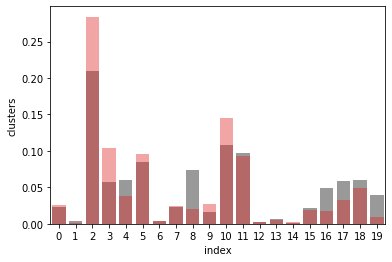

In [83]:
df_mailout_train['clusters'] = kmeans_train['clusters']
df_0 = df_mailout_train.query('RESPONSE==0')['clusters'].value_counts(normalize=True).reset_index()
sns.barplot(x = 'index', y = 'clusters', data=df_0, color='black', alpha=0.4)
sns.barplot(x = 'index', y = 'clusters', data=df_agg, color='red', alpha=0.4)

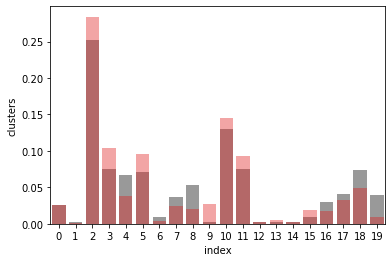

In [84]:
df_1 = df_mailout_train.query('RESPONSE==1')['clusters'].value_counts(normalize=True).reset_index()
sns.barplot(x = 'index', y = 'clusters', data=df_1, color='black', alpha=0.4)
sns.barplot(x = 'index', y = 'clusters', data=df_agg, color='red', alpha=0.4)

In [85]:
kmeans_train['RESPONSE'] = df_mailout_train['RESPONSE']

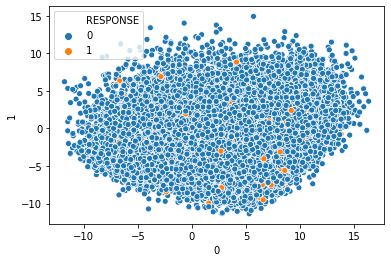

In [86]:
sns.scatterplot(x=0, y=1, data=kmeans_train, hue='RESPONSE')

In [87]:
kmeans_train.clusters.unique()

array([17,  5, 10,  3, 15, 11, 19,  2,  8,  0,  4,  9, 18, 16, 13,  7, 14,
        6, 12,  1])

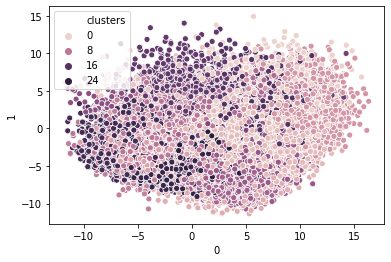

In [88]:
sns.scatterplot(x=0, y=1, data=kmeans_train, hue='clusters')

In [89]:
#kmeans_pipe.shape, kmeans_train.shape

In [90]:
#kmeans_pipe['RESPONSE']=1

In [91]:
#kmeans_pipe.shape, kmeans_train.shape

In [92]:
dummies = pd.get_dummies(kmeans_train.clusters, prefix='cluster')
kmeans_train_extended = pd.concat([kmeans_train.iloc[:,:-2],dummies], axis=1)
kmeans_train_extended.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
0,-5.267240,-4.682783,2.555490,6.882862,-0.269012,3.552548,-1.840130,-0.246685,-0.694523,-0.222302,1.133839,-0.373039,0.021856,-0.939402,-1.938746,1.522537,1.035527,0.681282,-2.321495,-2.142330,-0.880570,0.104297,0.344547,0.371301,0.386238,-1.482352,-1.271943,-0.746240,1.246341,2.396120,2.016150,0.091156,-1.568733,1.884847,-2.981639,1.850127,-1.428143,-2.075047,1.288044,0.465562,-0.339946,0.182625,-0.508845,-1.013438,0.562574,0.472867,0.359051,0.751743,0.424918,0.755407,1.374805,0.177631,1.117862,-1.613212,-0.740474,-0.461738,-0.641312,0.713196,-0.309789,0.317064,-0.741096,1.065255,-0.826898,-0.688845,0.265987,-1.526969,-1.234375,0.677675,-0.171211,0.927015,-0.249996,0.177999,0.203166,-1.428465,-0.223674,1.351920,-0.259587,0.497844,-0.571007,0.205837,0.346072,0.156151,0.087003,0.161242,-0.007062,0.615881,-0.648536,0.170966,-0.300763,-1.742862,0.648702,0.006532,1.193954,-0.685540,1.028127,0.199536,1.587013,0.084274,0.008595,-0.258132,-0.134825,0.200727,0.211525,0.449383,-0.615100,-0.087251,1.634853,-0.238606,-1.880810,-1.979347,0.420690,-0.547603,0.053761,-1.842922,-0.401139,-0.628062,-0.049533,0.524154,0.777137,-0.475407,0.297226,-0.229076,-0.431377,0.747979,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,9.689803,0.165826,-3.357596,1.243669,-2.281932,2.640778,-2.913675,-1.947850,1.150239,-0.378526,0.758954,-0.093471,1.820190,0.722259,4.230713,0.507390,0.885122,-1.031635,-0.873781,-1.156792,-1.101361,3.382390,0.567499,6.842714,4.452721,-1.532378,2.609588,1.103383,2.948687,-1.921008,1.544023,-1.692301,1.484493,0.275671,2.439190,-2.219932,1.804369,-2.214536,-0.490657,-2.775770,-4.512680,0.678522,0.704780,-0.596258,-1.760439,-0.211474,0.356606,1.041063,0.504099,0.814787,-1.376468,0.793294,-0.907210,-1.388078,0.037049,-1.278790,0.768271,1.867001,1.321469,-2.215332,1.117080,1.366778,-0.298311,0.057497,-1.308262,-1.351830,1.152324,0.650718,0.906975,-0.444552,-0.329703,0.753815,0.352075,-1.363092,-1.034220,-0.718442,-1.103229,0.407679,0.389455,0.791549,1.236125,-1.526184,-0.508539,1.893276,-1.893709,2.750213,0.846765,0.496193,1.928454,0.496898,0.922716,0.835390,3.674712,-1.920344,-1.995796,-2.220726,-1.573985,3.893657,-0.759397,0.202781,1.161446,0.648052,0.201582,-0.906442,-2.216631,0.014435,-0.878515,0.214846,-0.385050,0.790248,-0.288303,0.203182,-1.099569,-1.479792,0.828429,-0.928922,-0.635151,-1.520011,-0.803938,-0.795495,-0.110084,0.910468,-0.593223,-1.524735,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.235419,-4.259503,-2.834992,5.605305,5.116398,0.104928,3.849248,-1.093617,-1.470367,4.312312,-0.449089,1.332083,-1.292339,-2.523875,0.392272,-2.083216,-1.568139,0.303360,-2.772573,1.762214,0.883710,1.001884,-1.863555,0.817502,0.721020,-1.104481,-0.710398,0.436756,0.241833,-1.491881,-1.467756,2.814637,0.135583,0.183182,-2.038027,2.047113,0.533283,-1.591511,0.425227,0.396106,-0.953890,1.038066,0.292653,1.082992,0.215799,-0.953511,-0.373356,1.535931,2.908623,-2.041221,1.259627,-1.528032,-1.729227,-0.050332,-0.290534,0.619557,-1.536349,1.226265,-1.758801,-1.122084,-0.145577,0.435993,-0.628222,-0.218292,2.241820,-1.748054,-0.032365,1.451371,-2.251062,-1.005909,0.620211,-1.915436,-1.025733,-0.382745,1.071607,-0.906703,0.393651,0.054968,-0.780826,0.795346,-0.729841,0.178678,0.222046,0.607119,1.434887,0.799886,-0.158017,0.746880,0.427946,0.082136,-0.861952,-0.377976,-0.531146,0.290107,-0.821194,0.680573,0.519820,-1.358608,0.040091,-0.942588,1.688357,-0.660501,0

In [93]:
#kmeans_train_concat = pd.concat([kmeans_train, kmeans_pipe])

In [94]:
#dummies = pd.get_dummies(kmeans_train_concat.clusters, prefix='cluster')
#dummies = pd.get_dummies(kmeans_train.clusters, prefix='_cluster')
#kmeans_train_extended = pd.concat([kmeans_train.iloc[:,:-2],dummies], axis=1)
#kmeans_train_extended = pd.concat([kmeans_train_concat.iloc[:,:-2],dummies], axis=1)
#kmeans_train_extended.drop('clusters', axis=1, inplace=True)
#kmeans_train_extended.head()

In [95]:
#y = kmeans_train_concat.RESPONSE
#y = df_mailout_train.RESPONSE
#X = df_mailout_train.drop('RESPONSE', axis=1)
#X = kmeans_train.iloc[:,:-2].copy()
#X = kmeans_train_extended

In [96]:
y = kmeans_train.RESPONSE
X = kmeans_train_extended

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=34)
X_train2 = X_train.reset_index(drop=True)
y_train2 = y_train.reset_index(drop=True)
X_test2 = X_test.reset_index(drop=True)
y_test2 = y_test.reset_index(drop=True)

In [283]:
y.value_counts()

0    34660
1      436
Name: RESPONSE, dtype: int64

In [284]:
def skf_noSMOTE(X, y, model): 

    labels = []
    preds = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
    for train_indices, test_indices in skf.split(X, y):
    
        X_train_skf = X.iloc[train_indices,:]
        y_train_skf = y[train_indices]
    
        X_test_skf = X.iloc[test_indices,:]
        y_test_skf = y[test_indices]
        
        model.fit(X_train_skf, y_train_skf)            
        labels.extend(y_test_skf)
        preds.extend(model.predict(X_test_skf))
    
    print('accuracy :', accuracy_score(labels, preds)) 
    print('F1 :',f1_score(labels, preds))
    print('precision :', precision_score(labels, preds))
    print('recall :', recall_score(labels, preds))
    display(confusion_matrix(labels, preds))
    
    return model

In [286]:
model1 = AdaBoostClassifier(random_state=34, n_estimators=100, learning_rate=0.1)
model1 = skf_noSMOTE(X_train2, y_train2, model1)

accuracy : 0.9873201310728024
F1 : 0.0
precision : 0.0
recall : 0.0


array([[27720,     0],
       [  356,     0]])

In [287]:
model2 = RandomForestClassifier(random_state=34, n_estimators=1000)
model2 = skf_noSMOTE(X_train2, y_train2, model2)

accuracy : 0.9873201310728024
F1 : 0.0
precision : 0.0
recall : 0.0


array([[27720,     0],
       [  356,     0]])

In [288]:
#model3 = XGBClassifier(booster='dart', max_depth=5, n_estimators=100, n_jobs=-1, random_state=34)
model3 = XGBClassifier(random_state=34, n_estimators=1000, n_jobs=-1)
model3 = skf_noSMOTE(X_train2, y_train2, model3)

accuracy : 0.9873201310728024
F1 : 0.0
precision : 0.0
recall : 0.0


array([[27720,     0],
       [  356,     0]])

In [289]:
def skf_SMOTE(X, y, model):
    
    labels = []
    preds = []

    n = 0

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=34)
    for train_indices, test_indices in skf.split(X, y):

        X_train_skf = X.iloc[train_indices,:]
        y_train_skf = y[train_indices]
    
        X_test_skf = X.iloc[test_indices,:]
        y_test_skf = y[test_indices]
        
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(X_train_skf, y_train_skf)
        
        model.fit(X_res, y_res)
                
        labels.extend(y_res)
        preds.extend(model.predict(X_res))
    
    print('accuracy :', accuracy_score(labels, preds)) 
    print('F1 :',f1_score(labels, preds))
    print('precision :', precision_score(labels, preds))
    print('recall :', recall_score(labels, preds))
    display(confusion_matrix(labels, preds))
    
    return model

In [290]:
model4 = AdaBoostClassifier(random_state=34, n_estimators=1000, learning_rate=0.1)
model4 = skf_SMOTE(X_train2, y_train2, model4)

accuracy : 0.9275568181818182
F1 : 0.9285526860009518
precision : 0.9159610778180415
recall : 0.9414953102453102


array([[101302,   9578],
       [  6487, 104393]])

In [291]:
model5 = RandomForestClassifier(random_state=34, n_estimators=1000)
model5 = skf_SMOTE(X_train2, y_train2, model5)

accuracy : 1.0
F1 : 1.0
precision : 1.0
recall : 1.0


array([[110880,      0],
       [     0, 110880]])

In [292]:
#model6 = XGBClassifier(random_state=34)
#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
model6 = XGBClassifier(booster='dart', max_depth=7, learning_rate=0.05, n_estimators=1000, n_jobs=-1, random_state=34)
model6 = skf_SMOTE(X_train2, y_train2, model6)

accuracy : 1.0
F1 : 1.0
precision : 1.0
recall : 1.0


array([[110880,      0],
       [     0, 110880]])

In [293]:
def pred_model(model, X_test, y_test):
    y_preds = model.predict(X_test)
    print('accuracy :', accuracy_score(y_test, y_preds)) 
    print('F1 :',f1_score(y_test, y_preds))
    print('precision :', precision_score(y_test, y_preds))
    print('recall :', recall_score(y_test, y_preds))
    display(confusion_matrix(y_test, y_preds))

In [294]:
y_test.value_counts()

0    6940
1      80
Name: RESPONSE, dtype: int64

In [295]:
pred_model(model1, X_test, y_test)

accuracy : 0.9886039886039886
F1 : 0.0
precision : 0.0
recall : 0.0


array([[6940,    0],
       [  80,    0]])

In [296]:
pred_model(model2, X_test, y_test)

accuracy : 0.9886039886039886
F1 : 0.0
precision : 0.0
recall : 0.0


array([[6940,    0],
       [  80,    0]])

In [297]:
pred_model(model3, X_test, y_test)

accuracy : 0.9886039886039886
F1 : 0.0
precision : 0.0
recall : 0.0


array([[6940,    0],
       [  80,    0]])

In [298]:
pred_model(model4, X_test, y_test)

accuracy : 0.8874643874643875
F1 : 0.024691358024691357
precision : 0.0136986301369863
recall : 0.125


array([[6220,  720],
       [  70,   10]])

In [299]:
pred_model(model5, X_test, y_test)

accuracy : 0.9886039886039886
F1 : 0.0
precision : 0.0
recall : 0.0


array([[6940,    0],
       [  80,    0]])

In [300]:
pred_model(model6, X_test.values, y_test)

accuracy : 0.9878917378917379
F1 : 0.0
precision : 0.0
recall : 0.0


array([[6935,    5],
       [  80,    0]])

In [271]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='dart',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0,
                               learning_rate=0.02, max_delta_step=0,
                               max_depth=8, min_child_weight=5, missing=None,
                               n_estimators=10, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=34, silent=None, subsample=0.8,
               

In [272]:
clf.best_score_

0.03909224643222675

In [273]:
pred_model(clf.best_estimator_[1], X_test.values, y_test)

accuracy : 0.8777777777777778
F1 : 0.024999999999999998
precision : 0.01375
recall : 0.1375


array([[6151,  789],
       [  69,   11]])

In [ ]:
rf_model = Pipeline([
        ('sampling', SMOTE()),
        ('rf', RandomForestClassifier())
    ])

#parameters = {'xgb__objective':['binary:logistic'],
#              'xgb__learning_rate': [0.02, 0.05, 0.08, 0.1], #so called `eta` value
#              'xgb__max_depth': [6,7,8],
#              'xgb__subsample': [0.8],
#              'xgb__colsample_bytree': [0.7],
#              'xgb__n_estimators': [10,100,1000],
#              'xgb__seed': [34]}
parameters = { 
            "rf__n_estimators"      : [10,20,50,100,1000],
            "rf__max_features"      : ["auto", "sqrt", "log2"],
            "rf__min_samples_split" : [2,4,8],
            "rf__bootstrap": [True, False],
            }

kf = StratifiedKFold(n_splits=n_splits)
grid_rf = GridSearchCV(rf_model, parameters, n_jobs=32, cv=kf, scoring='accuracy', verbose=10)

grid_rf.fit(X, y)

In [301]:
xgb_model = Pipeline([
        ('sampling', SMOTE()),
        ('xgb', XGBClassifier())
    ])

#parameters = {'xgb__objective':['binary:logistic'],
#              'xgb__learning_rate': [0.02, 0.05, 0.08, 0.1], #so called `eta` value
#              'xgb__max_depth': [6,7,8],
#              'xgb__subsample': [0.8],
#              'xgb__colsample_bytree': [0.7],
#              'xgb__n_estimators': [10,100,1000],
#              'xgb__seed': [34]}

parameters = {'xgb__objective':['binary:logistic'],
              'xgb__learning_rate': [0.05, 0.08, 0.1], #so called `eta` value
              'xgb__max_depth': [7],
              'xgb__subsample': [0.8],
              'xgb__colsample_bytree': [0.7],
              'xgb__n_estimators': [10,100,1000],
              'xgb__seed': [34], 'n_jobs':[-1]}



kf = StratifiedKFold(n_splits=n_splits)
grid_xgb = GridSearchCV(xgb_model, parameters, n_jobs=32, cv=kf, scoring='accuracy', verbose=10)

grid_xgb.fit(X.values, y.values)

NameError: name 'n_splits' is not defined

In [277]:
clf2.best_score_

0.025362865836803503

In [279]:
clf2.best_estimator_

Pipeline(memory=None,
         steps=[('sampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0,
                               learning_rate=0.08, max_delta_step=0,
                               max_depth=7, min_child_weight=1, missing=None,
                               n_estimators=10, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=34, silent=None, subsample=0.8,
             


### MLP

In [149]:
y_train.value_counts()

0    27720
1      356
Name: RESPONSE, dtype: int64

In [150]:
27720/356

77.86516853932584

In [244]:
scaler2 = MinMaxScaler()
X_train2 = scaler2.fit_transform(X_train)

In [258]:
input_size = X_train.shape[1]
num_labels = 2
batch_size = 128
class_weight = {0: 1, 1: 78.}
y_train2 = to_categorical(y_train)
y_test2 = to_categorical(y_test)
X_train2 = np.reshape(X_train2, [-1, input_size])
X_test2 = np.reshape(X_test, [-1, input_size])

In [259]:
X_train2.shape, X_train.shape

((28076, 144), (28076, 144))

In [263]:
dropout=0.2
hidden_units = 256
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_labels))
# this is the output for one-hot vector
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 256)               37120     
_________________________________________________________________
activation_32 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_33 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 514       
__________

In [264]:
epochs = 500
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train2, y_train2, epochs=epochs, batch_size=batch_size, class_weight = class_weight, 
          validation_data=(X_test2, y_test2))

Train on 28076 samples, validate on 7020 samples
Epoch 1/500
28076/28076 [==============================] - 4s 148us/step - loss: 1.4164 - acc: 0.5018 - val_loss: 0.0924 - val_acc: 0.9886
Epoch 2/500
28076/28076 [==============================] - 3s 91us/step - loss: 1.3840 - acc: 0.4775 - val_loss: 0.1259 - val_acc: 0.9883
Epoch 3/500
28076/28076 [==============================] - 3s 89us/step - loss: 1.3783 - acc: 0.4894 - val_loss: 0.1465 - val_acc: 0.9872
Epoch 4/500
28076/28076 [==============================] - 3s 91us/step - loss: 1.3724 - acc: 0.4346 - val_loss: 0.2075 - val_acc: 0.9754
Epoch 5/500
28076/28076 [==============================] - 2s 86us/step - loss: 1.3733 - acc: 0.4562 - val_loss: 0.2583 - val_acc: 0.9642
Epoch 6/500
28076/28076 [==============================] - 2s 88us/step - loss: 1.3573 - acc: 0.5513 - val_loss: 0.3323 - val_acc: 0.9054
Epoch 7/500
28076/28076 [==============================] - 3s 90us/step - loss: 1.3563 - acc: 0.5941 - val_loss: 0.4807 - 

28076/28076 [==============================] - 3s 91us/step - loss: 1.1906 - acc: 0.6343 - val_loss: 2.4613 - val_acc: 0.5744
Epoch 60/500
28076/28076 [==============================] - 3s 92us/step - loss: 1.2127 - acc: 0.6372 - val_loss: 2.6892 - val_acc: 0.5410
Epoch 61/500
28076/28076 [==============================] - 3s 90us/step - loss: 1.1974 - acc: 0.6159 - val_loss: 2.6478 - val_acc: 0.5517
Epoch 62/500
28076/28076 [==============================] - 3s 91us/step - loss: 1.1728 - acc: 0.6730 - val_loss: 2.9375 - val_acc: 0.5412
Epoch 63/500
28076/28076 [==============================] - 3s 91us/step - loss: 1.2018 - acc: 0.6415 - val_loss: 2.3152 - val_acc: 0.5668
Epoch 64/500
28076/28076 [==============================] - 3s 90us/step - loss: 1.1899 - acc: 0.6641 - val_loss: 2.7421 - val_acc: 0.5541
Epoch 65/500
28076/28076 [==============================] - 2s 87us/step - loss: 1.1670 - acc: 0.6521 - val_loss: 2.8100 - val_acc: 0.5581
Epoch 66/500
28076/28076 [==============

Epoch 118/500
28076/28076 [==============================] - 3s 92us/step - loss: 1.0855 - acc: 0.7006 - val_loss: 2.3355 - val_acc: 0.6665
Epoch 119/500
28076/28076 [==============================] - 3s 90us/step - loss: 1.1270 - acc: 0.6889 - val_loss: 2.4535 - val_acc: 0.6597
Epoch 120/500
28076/28076 [==============================] - 2s 81us/step - loss: 1.0820 - acc: 0.6633 - val_loss: 2.4889 - val_acc: 0.6523
Epoch 121/500
28076/28076 [==============================] - 2s 88us/step - loss: 1.0989 - acc: 0.6862 - val_loss: 2.7513 - val_acc: 0.6400
Epoch 122/500
28076/28076 [==============================] - 2s 89us/step - loss: 1.0905 - acc: 0.6940 - val_loss: 2.6245 - val_acc: 0.6406
Epoch 123/500
28076/28076 [==============================] - 3s 93us/step - loss: 1.1228 - acc: 0.7198 - val_loss: 2.9787 - val_acc: 0.6308
Epoch 124/500
28076/28076 [==============================] - 2s 88us/step - loss: 1.1155 - acc: 0.7034 - val_loss: 2.7499 - val_acc: 0.6393
Epoch 125/500
28076/

28076/28076 [==============================] - 3s 91us/step - loss: 1.0629 - acc: 0.7346 - val_loss: 2.4525 - val_acc: 0.6526
Epoch 177/500
28076/28076 [==============================] - 3s 96us/step - loss: 1.0176 - acc: 0.7172 - val_loss: 3.1920 - val_acc: 0.6182
Epoch 178/500
28076/28076 [==============================] - 3s 93us/step - loss: 1.0680 - acc: 0.7339 - val_loss: 2.7490 - val_acc: 0.6356
Epoch 179/500
28076/28076 [==============================] - 3s 91us/step - loss: 1.0782 - acc: 0.7552 - val_loss: 3.2060 - val_acc: 0.6034
Epoch 180/500
28076/28076 [==============================] - 2s 87us/step - loss: 1.0693 - acc: 0.7494 - val_loss: 2.1861 - val_acc: 0.6722
Epoch 181/500
28076/28076 [==============================] - 2s 84us/step - loss: 1.0394 - acc: 0.7363 - val_loss: 1.7290 - val_acc: 0.6939
Epoch 182/500
28076/28076 [==============================] - 2s 86us/step - loss: 1.0496 - acc: 0.7026 - val_loss: 1.2432 - val_acc: 0.7546
Epoch 183/500
28076/28076 [=======

28076/28076 [==============================] - 3s 99us/step - loss: 1.1006 - acc: 0.7369 - val_loss: 0.8513 - val_acc: 0.8209
Epoch 235/500
28076/28076 [==============================] - 3s 103us/step - loss: 1.0937 - acc: 0.7500 - val_loss: 0.4404 - val_acc: 0.8990
Epoch 236/500
28076/28076 [==============================] - 3s 98us/step - loss: 1.0981 - acc: 0.7462 - val_loss: 0.3353 - val_acc: 0.9222
Epoch 237/500
28076/28076 [==============================] - 3s 99us/step - loss: 1.1100 - acc: 0.7484 - val_loss: 0.1882 - val_acc: 0.9641
Epoch 238/500
28076/28076 [==============================] - 3s 102us/step - loss: 1.0606 - acc: 0.7541 - val_loss: 0.6839 - val_acc: 0.8450
Epoch 239/500
28076/28076 [==============================] - 3s 94us/step - loss: 1.0867 - acc: 0.7436 - val_loss: 0.2706 - val_acc: 0.9369
Epoch 240/500
28076/28076 [==============================] - 3s 94us/step - loss: 1.1220 - acc: 0.7329 - val_loss: 0.3130 - val_acc: 0.9293
Epoch 241/500
28076/28076 [=====

28076/28076 [==============================] - 3s 90us/step - loss: 1.0901 - acc: 0.7624 - val_loss: 0.2722 - val_acc: 0.9450
Epoch 293/500
28076/28076 [==============================] - 3s 106us/step - loss: 1.0717 - acc: 0.7647 - val_loss: 0.3961 - val_acc: 0.9160
Epoch 294/500
28076/28076 [==============================] - 3s 91us/step - loss: 1.0493 - acc: 0.7489 - val_loss: 0.3252 - val_acc: 0.9338
Epoch 295/500
28076/28076 [==============================] - 3s 95us/step - loss: 1.0882 - acc: 0.7483 - val_loss: 0.2108 - val_acc: 0.9648
Epoch 296/500
28076/28076 [==============================] - 3s 96us/step - loss: 1.0898 - acc: 0.7171 - val_loss: 0.2262 - val_acc: 0.9519
Epoch 297/500
28076/28076 [==============================] - 3s 101us/step - loss: 1.0980 - acc: 0.7369 - val_loss: 0.2506 - val_acc: 0.9444
Epoch 298/500
28076/28076 [==============================] - 3s 103us/step - loss: 1.0199 - acc: 0.7498 - val_loss: 0.1889 - val_acc: 0.9675
Epoch 299/500
28076/28076 [====

28076/28076 [==============================] - 3s 97us/step - loss: 1.0358 - acc: 0.7602 - val_loss: 0.2107 - val_acc: 0.9726
Epoch 351/500
28076/28076 [==============================] - 3s 94us/step - loss: 1.0075 - acc: 0.7708 - val_loss: 0.2270 - val_acc: 0.9685
Epoch 352/500
28076/28076 [==============================] - 3s 94us/step - loss: 1.0307 - acc: 0.7618 - val_loss: 0.2054 - val_acc: 0.9742
Epoch 353/500
28076/28076 [==============================] - 3s 96us/step - loss: 1.0864 - acc: 0.7665 - val_loss: 0.2297 - val_acc: 0.9642
Epoch 354/500
28076/28076 [==============================] - 3s 101us/step - loss: 1.0691 - acc: 0.7454 - val_loss: 0.1939 - val_acc: 0.9769
Epoch 355/500
28076/28076 [==============================] - 3s 93us/step - loss: 1.0483 - acc: 0.7540 - val_loss: 0.1838 - val_acc: 0.9806
Epoch 356/500
28076/28076 [==============================] - 3s 92us/step - loss: 1.0376 - acc: 0.7598 - val_loss: 0.1835 - val_acc: 0.9806
Epoch 357/500
28076/28076 [======

28076/28076 [==============================] - 3s 93us/step - loss: 1.0769 - acc: 0.7748 - val_loss: 0.2198 - val_acc: 0.9661
Epoch 409/500
28076/28076 [==============================] - 3s 90us/step - loss: 1.1105 - acc: 0.7681 - val_loss: 0.1862 - val_acc: 0.9788
Epoch 410/500
28076/28076 [==============================] - 2s 86us/step - loss: 1.0716 - acc: 0.7999 - val_loss: 0.1994 - val_acc: 0.9738
Epoch 411/500
28076/28076 [==============================] - 2s 83us/step - loss: 1.0826 - acc: 0.7999 - val_loss: 0.1752 - val_acc: 0.9859
Epoch 412/500
28076/28076 [==============================] - 3s 90us/step - loss: 1.0901 - acc: 0.7964 - val_loss: 0.1770 - val_acc: 0.9862
Epoch 413/500
28076/28076 [==============================] - 3s 95us/step - loss: 1.1076 - acc: 0.8005 - val_loss: 0.1898 - val_acc: 0.9796
Epoch 414/500
28076/28076 [==============================] - 2s 81us/step - loss: 1.1070 - acc: 0.7968 - val_loss: 0.1828 - val_acc: 0.9822
Epoch 415/500
28076/28076 [=======

28076/28076 [==============================] - 3s 96us/step - loss: 1.1424 - acc: 0.7955 - val_loss: 0.2256 - val_acc: 0.9739
Epoch 467/500
28076/28076 [==============================] - 2s 86us/step - loss: 1.1922 - acc: 0.8317 - val_loss: 0.2039 - val_acc: 0.9783
Epoch 468/500
28076/28076 [==============================] - 2s 78us/step - loss: 1.2615 - acc: 0.8148 - val_loss: 0.2090 - val_acc: 0.9762
Epoch 469/500
28076/28076 [==============================] - 2s 85us/step - loss: 1.1926 - acc: 0.8229 - val_loss: 0.2416 - val_acc: 0.9671
Epoch 470/500
28076/28076 [==============================] - 2s 84us/step - loss: 1.1951 - acc: 0.8009 - val_loss: 0.3128 - val_acc: 0.9538
Epoch 471/500
28076/28076 [==============================] - 3s 90us/step - loss: 1.1765 - acc: 0.8285 - val_loss: 0.2442 - val_acc: 0.9674
Epoch 472/500
28076/28076 [==============================] - 2s 87us/step - loss: 1.1947 - acc: 0.8354 - val_loss: 0.2039 - val_acc: 0.9779
Epoch 473/500
28076/28076 [=======

In [254]:
def predict_nn(X, y, model):
    
    y_preds = model.predict(X)

    df_pred = pd.DataFrame(y[:,0].astype('int64'), columns=['true'])
    df_pred['true'] = df_pred['true'].apply(lambda x: 0 if x==1 else 1)
    df_pred['preds'] = np.array(y_preds[:,0])
    df_pred['preds'] = df_pred['preds'].apply(lambda x: 1 if x < 0.5 else 0)

    class0 = df_pred[(df_pred['true']==1) & (df_pred['preds']==1)].shape[0]
    #print(class0)
    all_entries = df_pred.shape[0]
    print(accuracy_score(df_pred['true'], df_pred['preds']))
    print(f1_score(df_pred['true'], df_pred['preds']))
    


In [265]:
predict_nn(X_test2, y_test2.copy(), model)

0.9810541310541311
0.029197080291970805


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv')

In [ ]:
, kmeans_pipe = pipeline(customers)

## Code Bank

In [ ]:
#customer = (customer.pipe(pre_clean)
#      .pipe(missing_values)
#      .pipe(drop_features, arg1=445E3)
#      .pipe(drop_rows).pipe(impute_calc)
#      .pipe(pragende_jugendjahre)
#      .pipe(cameo_intl_2015)
#      .pipe(lp_lebensphase_fein)
#      .pipe(lp_lebensphase_grob)
#      .pipe(adjust_types))
#
#def dummies_scale(df):
#    df_onehot = pd.DataFrame(data = onehot.transform(df[list_onehot]).todense(), 
#                         columns=onehot.get_feature_names())
#    df = pd.concat([df.drop(list_onehot, axis=1), df_onehot], axis=1)
#    df[list_scale] = scaler.transform(df[list_scale])
#    return df
#
#dummies_scale(customer)